# Initial DINO model

This notebook has the first pass at creating a tree classification model based on DINOv2. It takes as input a tree image, and outputs a class. The available classes are determined by the `classes.json` file for the Laurentian trees dataset.

DINOv2 is run over the image, and then linear probing is done on the output tokens. It's got really bad accuracy and is having difficulty learning.

A number of things could be tried here to improve it:
- Using KNN instead of linear probing, since these classes may not be linearly separable even in token space
- Token-level classification (Martin thinks this is the best approach)
- Adjusting the image pre-processing. Currently they're all scaled to 256*256, which could cause stretching for non-square inputs
- Only using tokens where the tree is located. Since one version of the input uses masked tree images with transparent backgrounds, we could try to just use the non-transparent pixels.

In [1]:
import torch
import torch.nn as nn
import os
from transformers import Dinov2Model, Dinov2PreTrainedModel
from PIL import Image
import json
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations as A
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm.auto import tqdm

/home/matt/miniconda3/envs/scratch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Create dataloaders

class TreeDataset(Dataset):
    def __init__(self, root_dir, transform, zones=['Z1', 'Z2'], class_map_path='./data/classes.json'):
        with open(class_map_path, 'r') as f:
            self.class_map = {v:int(k) for k, v in json.load(f).items()}
        
        self.root_dir = root_dir
        self.classes = [d for d in os.listdir(root_dir)]
        self.image_files = []
        self.transform = transform
        for c in self.classes:
            for img in os.listdir(os.path.join(root_dir, c)):
                if any(z for z in zones if z in img):
                    self.image_files.append((os.path.join(root_dir, c, img), self.class_map[c]))
        self.toTensor = transforms.ToTensor()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path, c = self.image_files[idx]
        img_np = np.array(Image.open(img_path))[:,:,:3]
        transformed = self.transform(image=img_np)['image']
        return self.toTensor(transformed), torch.tensor(c)

# These are the mean/std I took from the complete tiff of Z1
ADE_MEAN = np.array([51.61087416176021, 70.54108897685563, 43.65073194868197]) / 255
ADE_STD = np.array([66.21302035582556, 82.09431586857384, 54.93294965405881]) / 255

train_transform = A.Compose([
    A.Resize(width=224, height=224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

val_transform = A.Compose([
    A.Resize(width=224, height=224),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

train_dataset = TreeDataset('./data/tree_classification', train_transform)
val_dataset = TreeDataset('./data/tree_classification', val_transform, zones=['Z3'])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)



# Pick this up tomorrow: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DINOv2/Train_a_linear_classifier_on_top_of_DINOv2_for_semantic_segmentation.ipynb


In [3]:
class Dinov2ForClassification(Dinov2PreTrainedModel):
  def __init__(self, config):
    super().__init__(config)
    self.config = config
    self.dinov2 = Dinov2Model(config)
    self.classifier = nn.Linear(config.hidden_size * 256, config.num_labels)


  def forward(self, pixel_values, output_hidden_states=False, output_attentions=False, labels=None):
    # use frozen features
    outputs = self.dinov2(pixel_values,
                            output_hidden_states=output_hidden_states,
                            output_attentions=output_attentions)
    
    # get the patch embeddings - so we exclude the CLS token
    patch_embeddings = torch.flatten(outputs.last_hidden_state[:,1:,:], start_dim=1)

    # convert to logits and upsample to the size of the pixel values
    logits = self.classifier(patch_embeddings)

    return nn.functional.softmax(logits, dim=1)

model = Dinov2ForClassification.from_pretrained("facebook/dinov2-base", num_labels=29)

# freeze DINOv2 parameters
for name, param in model.named_parameters():
  if name.startswith("dinov2"):
    param.requires_grad = False

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Some weights of Dinov2ForClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dinov2ForClassification(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            

In [4]:
learning_rate = 1e-5
epochs = 30

optimizer = AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
model.train()
epoch_train_losses = []
epoch_val_losses = []

for epoch in range(epochs):
  train_loss = 0
  val_loss = 0
  print("Epoch:", epoch)

  for idx, batch in enumerate(tqdm(train_dataloader)):
    data = batch[0].to(device)
    targets = nn.functional.one_hot(batch[1], num_classes=29).float().to(device)
    
    # forward pass
    outputs = model(data)
    loss = loss_fn(outputs, targets)

    loss.backward()
    optimizer.step()

    # zero the parameter gradients
    optimizer.zero_grad()

    train_loss += loss.item() / targets.shape[0]
  
  train_loss /= len(train_dataloader)
  print(f'  Train loss: {train_loss}')

  for idx, batch in enumerate(tqdm(val_dataloader)):
    data = batch[0].to(device)
    targets = nn.functional.one_hot(batch[1], num_classes=29).float().to(device)
    outputs = model(data)
    loss = loss_fn(outputs, targets)
    optimizer.zero_grad()
    val_loss += loss.item() / targets.shape[0]
  
  val_loss /= len(val_dataloader)
  print(f'  Val loss: {val_loss}')
  epoch_train_losses.append(train_loss)
  epoch_val_losses.append(val_loss)


Epoch: 0


100%|██████████| 1143/1143 [01:47<00:00, 10.60it/s]


  Train loss: 0.20025009928517246


100%|██████████| 291/291 [00:25<00:00, 11.27it/s]


  Val loss: 0.1994289252868633
Epoch: 1


100%|██████████| 1143/1143 [01:46<00:00, 10.76it/s]


  Train loss: 0.19336870504332965


100%|██████████| 291/291 [00:25<00:00, 11.31it/s]


  Val loss: 0.19305299335124157
Epoch: 2


100%|██████████| 1143/1143 [01:41<00:00, 11.23it/s]


  Train loss: 0.1862717370061841


100%|██████████| 291/291 [00:23<00:00, 12.26it/s]


  Val loss: 0.1908768718902188
Epoch: 3


100%|██████████| 1143/1143 [01:40<00:00, 11.38it/s]


  Train loss: 0.18350543085671472


100%|██████████| 291/291 [00:23<00:00, 12.23it/s]


  Val loss: 0.19018230853007012
Epoch: 4


100%|██████████| 1143/1143 [01:38<00:00, 11.62it/s]


  Train loss: 0.18266032091223766


100%|██████████| 291/291 [00:23<00:00, 12.23it/s]


  Val loss: 0.18892218460332078
Epoch: 5


100%|██████████| 1143/1143 [01:38<00:00, 11.64it/s]


  Train loss: 0.1821043343003758


100%|██████████| 291/291 [00:23<00:00, 12.28it/s]


  Val loss: 0.18897526023518998
Epoch: 6


100%|██████████| 1143/1143 [01:38<00:00, 11.59it/s]


  Train loss: 0.18148494605056464


100%|██████████| 291/291 [00:23<00:00, 12.24it/s]


  Val loss: 0.18892613470144698
Epoch: 7


100%|██████████| 1143/1143 [01:39<00:00, 11.54it/s]


  Train loss: 0.18127816536138688


100%|██████████| 291/291 [00:23<00:00, 12.27it/s]


  Val loss: 0.18830422233674943
Epoch: 8


100%|██████████| 1143/1143 [01:38<00:00, 11.59it/s]


  Train loss: 0.181061204050261


100%|██████████| 291/291 [00:23<00:00, 12.14it/s]


  Val loss: 0.18872597839209632
Epoch: 9


100%|██████████| 1143/1143 [01:38<00:00, 11.60it/s]


  Train loss: 0.18070296951009845


100%|██████████| 291/291 [00:23<00:00, 12.24it/s]


  Val loss: 0.18789616225101693
Epoch: 10


100%|██████████| 1143/1143 [01:38<00:00, 11.57it/s]


  Train loss: 0.1805228158662117


100%|██████████| 291/291 [00:23<00:00, 12.22it/s]


  Val loss: 0.18799661764574216
Epoch: 11


100%|██████████| 1143/1143 [01:38<00:00, 11.63it/s]


  Train loss: 0.1802867946662302


100%|██████████| 291/291 [00:23<00:00, 12.26it/s]


  Val loss: 0.18789993138452576
Epoch: 12


100%|██████████| 1143/1143 [01:38<00:00, 11.56it/s]


  Train loss: 0.18016578065441663


100%|██████████| 291/291 [00:25<00:00, 11.22it/s]


  Val loss: 0.18786614452235886
Epoch: 13


100%|██████████| 1143/1143 [01:51<00:00, 10.29it/s]


  Train loss: 0.1800765721608126


100%|██████████| 291/291 [00:26<00:00, 10.93it/s]


  Val loss: 0.18760777206969834
Epoch: 14


100%|██████████| 1143/1143 [01:48<00:00, 10.52it/s]


  Train loss: 0.179818658899656


100%|██████████| 291/291 [00:26<00:00, 11.11it/s]


  Val loss: 0.18751371746620363
Epoch: 15


100%|██████████| 1143/1143 [01:47<00:00, 10.61it/s]


  Train loss: 0.17989935165993082


100%|██████████| 291/291 [00:25<00:00, 11.23it/s]


  Val loss: 0.18795047940052662
Epoch: 16


100%|██████████| 1143/1143 [01:47<00:00, 10.61it/s]


  Train loss: 0.17970113411923824


100%|██████████| 291/291 [00:26<00:00, 11.17it/s]


  Val loss: 0.1874942977608684
Epoch: 17


100%|██████████| 1143/1143 [01:46<00:00, 10.72it/s]


  Train loss: 0.17956419698470324


100%|██████████| 291/291 [00:25<00:00, 11.21it/s]


  Val loss: 0.18810789472458697
Epoch: 18


100%|██████████| 1143/1143 [01:46<00:00, 10.68it/s]


  Train loss: 0.17943543966204475


100%|██████████| 291/291 [00:25<00:00, 11.30it/s]


  Val loss: 0.18755724805941695
Epoch: 19


100%|██████████| 1143/1143 [01:46<00:00, 10.71it/s]


  Train loss: 0.1794008505469545


100%|██████████| 291/291 [00:25<00:00, 11.28it/s]


  Val loss: 0.1878048131453622
Epoch: 20


100%|██████████| 1143/1143 [01:47<00:00, 10.59it/s]


  Train loss: 0.17942911918394835


100%|██████████| 291/291 [00:26<00:00, 11.13it/s]


  Val loss: 0.18761794259867717
Epoch: 21


100%|██████████| 1143/1143 [01:48<00:00, 10.54it/s]


  Train loss: 0.17926858763160772


100%|██████████| 291/291 [00:26<00:00, 10.84it/s]


  Val loss: 0.1874990677710661
Epoch: 22


100%|██████████| 1143/1143 [01:49<00:00, 10.43it/s]


  Train loss: 0.17920558721687538


100%|██████████| 291/291 [00:26<00:00, 11.05it/s]


  Val loss: 0.18732981541517266
Epoch: 23


100%|██████████| 1143/1143 [01:49<00:00, 10.46it/s]


  Train loss: 0.1790695436174997


100%|██████████| 291/291 [00:25<00:00, 11.22it/s]


  Val loss: 0.1877865413107823
Epoch: 24


100%|██████████| 1143/1143 [01:48<00:00, 10.55it/s]


  Train loss: 0.17896338492918723


100%|██████████| 291/291 [00:26<00:00, 11.13it/s]


  Val loss: 0.18734302957033375
Epoch: 25


100%|██████████| 1143/1143 [01:47<00:00, 10.63it/s]


  Train loss: 0.1788913686340145


100%|██████████| 291/291 [00:25<00:00, 11.24it/s]


  Val loss: 0.18747760419993056
Epoch: 26


100%|██████████| 1143/1143 [01:49<00:00, 10.45it/s]


  Train loss: 0.17883452302462577


100%|██████████| 291/291 [00:26<00:00, 11.07it/s]


  Val loss: 0.1875243406422769
Epoch: 27


100%|██████████| 1143/1143 [01:47<00:00, 10.67it/s]


  Train loss: 0.17884634591619486


100%|██████████| 291/291 [00:25<00:00, 11.28it/s]


  Val loss: 0.1875531509365003
Epoch: 28


100%|██████████| 1143/1143 [01:46<00:00, 10.70it/s]


  Train loss: 0.1787867089660149


100%|██████████| 291/291 [00:26<00:00, 11.19it/s]


  Val loss: 0.18835242455153123
Epoch: 29


100%|██████████| 1143/1143 [01:46<00:00, 10.72it/s]


  Train loss: 0.17868865498407618


100%|██████████| 291/291 [00:25<00:00, 11.23it/s]

  Val loss: 0.18754057746982247


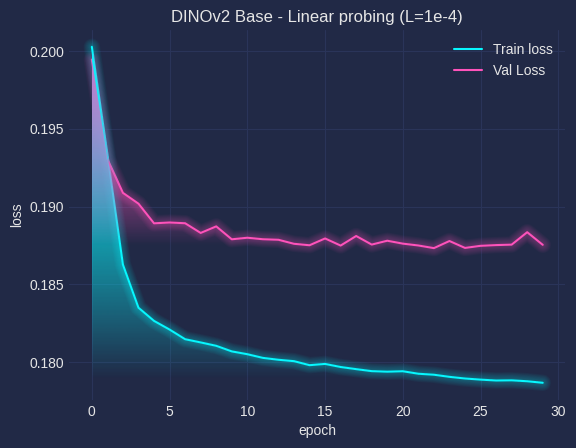

NameError: name 'run' is not defined

In [8]:
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
x_values = range(len(epoch_train_losses))
plt.plot(x_values, epoch_train_losses, label='Train loss')
plt.plot(x_values, epoch_val_losses, label='Val Loss')

# Adding title and labels
plt.title(f'DINOv2 Base - Linear probing (L=1e-4)')
plt.xlabel('epoch')
plt.ylabel('loss')

# Add a legend
plt.legend()

# Show the plot
mplcyberpunk.add_glow_effects(gradient_fill=0.5)
mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.5)
plt.show()
plt.savefig(os.path.join('runs', run, 'loss.png'))